## Description:
这里用Pytorch搭建AFM Model在cretio数据集上进行点击率预测的任务

In [1]:
"""导入包"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import itertools

# pytorch
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary, Model
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 数据准备

In [2]:
file_path = './preprocessed_data/'

In [3]:
def prepared_data(file_path):
    # 读入训练集， 验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [4]:
"""导入数据"""
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [5]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [6]:
# 看一眼数据
for x, y in iter(dl_train):
    print(x.shape, y)
    break

torch.Size([32, 39]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])


## 构建模型
这里依然是使用继承nn.Modult基类构建模型， 并辅助应用模型容器进行封装， AFM的模型架构如下：

![](https://img-blog.csdnimg.cn/20210102204934171.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3d1emhvbmdxaWFuZw==,size_1,color_FFFFFF,t_70#pic_center)

这个模型在NFM的基础上加入了Attention机制，  我们需要实现这个Attention网络， 不用DNN模块了。

In [7]:
class Dnn(nn.Module):
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout = 0.
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):  
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)    
        x = self.dropout(x) 
        return x

In [8]:
class Attention_layer(nn.Module):
    def __init__(self, att_units):
        """
        :param att_units: [embed_dim, att_vector]
        """
        super(Attention_layer, self).__init__()
        
        self.att_w = nn.Linear(att_units[0], att_units[1])
        self.att_dense = nn.Linear(att_units[1], 1)
    
    def forward(self, bi_interaction):     # bi_interaction (None, (field_num*(field_num-1)_/2, embed_dim)
        a = self.att_w(bi_interaction)    # (None, (field_num*(field_num-1)_/2, t)
        a = F.relu(a)             # (None, (field_num*(field_num-1)_/2, t)
        att_scores = self.att_dense(a)  # (None, (field_num*(field_num-1)_/2, 1)
        att_weight = F.softmax(att_scores, dim=1)  #  (None, (field_num*(field_num-1)_/2, 1)

        att_out = torch.sum(att_weight * bi_interaction, dim=1)   # (None, embed_dim)
        return att_out     

In [9]:
class AFM(nn.Module):
    def __init__(self, feature_columns, mode, hidden_units, att_vector=8, dropout=0.5, useDNN=False):
        """
        AFM:
        :param feature_columns: 特征信息， 这个传入的是fea_cols array[0] dense_info  array[1] sparse_info
        :param mode: A string, 三种模式, 'max': max pooling, 'avg': average pooling 'att', Attention
        :param att_vector: 注意力网络的隐藏层单元个数
        :param hidden_units: DNN网络的隐藏单元个数， 一个列表的形式， 列表的长度代表层数， 每个元素代表每一层神经元个数， lambda文里面没加
        :param dropout: Dropout比率
        :param useDNN: 默认不使用DNN网络
        """
        super(AFM, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        self.mode = mode
        self.useDNN = useDNN
        
        # embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        # 如果是注意机制的话，这里需要加一个注意力网络
        if self.mode == 'att':   
            self.attention = Attention_layer([self.sparse_feature_cols[0]['embed_dim'], att_vector])
            
        # 如果使用DNN的话， 这里需要初始化DNN网络
        if self.useDNN:
            # 这里要注意Pytorch的linear和tf的dense的不同之处， 前者的linear需要输入特征和输出特征维度， 而传入的hidden_units的第一个是第一层隐藏的神经单元个数，这里需要加个输入维度
            self.fea_num = len(self.dense_feature_cols) + self.sparse_feature_cols[0]['embed_dim']
            hidden_units.insert(0, self.fea_num)

            self.bn = nn.BatchNorm1d(self.fea_num)     
            self.dnn_network = Dnn(hidden_units, dropout)
            self.nn_final_linear = nn.Linear(hidden_units[-1], 1)
        else:
            self.fea_num = len(self.dense_feature_cols) + self.sparse_feature_cols[0]['embed_dim']
            self.nn_final_linear = nn.Linear(self.fea_num, 1)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()       # 转成long类型才能作为nn.embedding的输入
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.stack(sparse_embeds)     # embedding堆起来， (field_dim, None, embed_dim)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))
        # 这里得到embedding向量之后 sparse_embeds(None, field_num, embed_dim)
        # 下面进行两两交叉， 注意这时候不能加和了，也就是NFM的那个计算公式不能用， 这里两两交叉的结果要进入Attention
        # 两两交叉enbedding之后的结果是一个(None, (field_num*field_num-1)/2, embed_dim) 
        # 这里实现的时候采用一个技巧就是组合
        #比如fild_num有4个的话，那么组合embeding就是[0,1] [0,2],[0,3],[1,2],[1,3],[2,3]位置的embedding乘积操作
        first = []
        second = []
        for f, s in itertools.combinations(range(sparse_embeds.shape[1]), 2):
            first.append(f)
            second.append(s)
        # 取出first位置的embedding  假设field是3的话，就是[0, 0, 0, 1, 1, 2]位置的embedding
        p = sparse_embeds[:, first, :]     # (None, (field_num*(field_num-1)_/2, embed_dim)
        q = sparse_embeds[:, second, :]   # (None, (field_num*(field_num-1)_/2, embed_dim)
        bi_interaction = p * q    # (None, (field_num*(field_num-1)_/2, embed_dim)
        
        if self.mode == 'max':
            att_out = torch.sum(bi_interaction, dim=1)  #  (None, embed_dim)
        elif self.mode == 'avg':
            att_out = torch.mean(bi_interaction, dim=1)  # (None, embed_dim)
        else:
            # 注意力网络
            att_out = self.attention(bi_interaction)  # (None, embed_dim)
        
        # 把离散特征和连续特征进行拼接
        x = torch.cat([att_out, dense_inputs], dim=-1)
        
        if not self.useDNN:
            outputs = F.sigmoid(self.nn_final_linear(x))
        else:
            # BatchNormalization
            x = self.bn(x)
            # deep
            dnn_outputs = self.nn_final_linear(self.dnn_network(x))
            outputs = F.sigmoid(dnn_outputs)
        
        return outputs

In [25]:
# 建立模型
hidden_units = [128, 64, 32]
dnn_dropout = 0.

model = AFM(fea_cols, 'att', hidden_units, dropout=dnn_dropout, useDNN=True)

In [26]:
summary(model, input_shape=(trn_x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                    [-1, 8]             632
         Embedding-2                    [-1, 8]           2,016
         Embedding-3                    [-1, 8]          10,344
         Embedding-4                    [-1, 8]           8,344
         Embedding-5                    [-1, 8]             240
         Embedding-6                    [-1, 8]              56
         Embedding-7                    [-1, 8]           9,312
         Embedding-8                    [-1, 8]             312
         Embedding-9                    [-1, 8]              16
        Embedding-10                    [-1, 8]           7,264
        Embedding-11                    [-1, 8]           7,408
        Embedding-12                    [-1, 8]           9,912
        Embedding-13                    [-1, 8]           6,592
        Embedding-14                   

In [27]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.5366],
        [0.5351],
        [0.5415],
        [0.5341],
        [0.5343],
        [0.5534],
        [0.5365],
        [0.5381],
        [0.5502],
        [0.5351],
        [0.5348],
        [0.5571],
        [0.5373],
        [0.5362],
        [0.5345],
        [0.5389],
        [0.5379],
        [0.5462],
        [0.5422],
        [0.5381],
        [0.5354],
        [0.5387],
        [0.5361],
        [0.5383],
        [0.5382],
        [0.5269],
        [0.5370],
        [0.5385],
        [0.5331],
        [0.5486],
        [0.5386],
        [0.5365]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [28]:
# 模型的相关配置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [29]:
# 脚本训练风格
epochs = 8
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features);
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2021-01-17 00:53:52
[step=10] loss: 0.713, auc: 0.506
[step=20] loss: 0.679, auc: 0.522
[step=30] loss: 0.647, auc: 0.495
[step=40] loss: 0.615, auc: 0.512

EPOCH=1, loss=0.615, auc = 0.512, val_loss=0.474, val_auc = 0.617

================================================================================2021-01-17 00:53:53
[step=10] loss: 0.513, auc: 0.559
[step=20] loss: 0.501, auc: 0.630
[step=30] loss: 0.505, auc: 0.654
[step=40] loss: 0.500, auc: 0.661

EPOCH=2, loss=0.500, auc = 0.661, val_loss=0.437, val_auc = 0.624

================================================================================2021-01-17 00:53:54
[step=10] loss: 0.476, auc: 0.730
[step=20] loss: 0.487, auc: 0.743
[step=30] loss: 0.483, auc: 0.718
[step=40] loss: 0.483, auc: 0.714

EPOCH=3, loss=0.483, auc = 0.714, val_loss=0.430, val_auc = 0.615

================================================================================

In [15]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.717326,0.378402,0.707316,0.339038
1,2.0,0.691769,0.401785,0.673586,0.340718
2,3.0,0.658877,0.437010,0.628479,0.416281
3,4.0,0.618143,0.504018,0.575567,0.421431
4,5.0,0.576610,0.553058,0.529029,0.457773
5,6.0,0.545148,0.625388,0.493273,0.513164
6,7.0,0.524586,0.657078,0.473878,0.531904
7,8.0,0.513703,0.710741,0.461418,0.563895


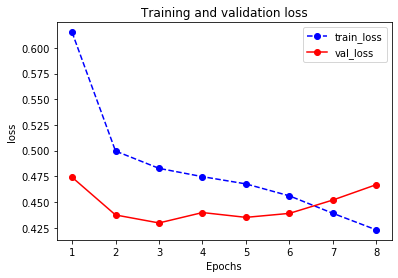

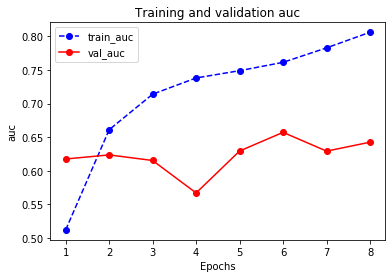

In [30]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [31]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [32]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [33]:
# 模型的保存与使用
torch.save(model, './model/AFM.pkl')

In [34]:
net_clone = torch.load('./model/AFM.pkl')

In [35]:
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [36]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      